
# CEWA 568 Snow Hydrology - Spring 2023
## Homework 4: Comparing snow flux and wind speed data at Kettle Ponds

Daniel Hogan

---

In [4]:
# import libraries we'll need
import urllib
import pandas as pd
import datetime as dt
import xarray as xr
import matplotlib.pyplot as plt
import os
%matplotlib inline

### Problem 1: Late December SWE mystery

In [5]:
# Pull in wind and flowcapt sensor data
sos_dataset_60min=xr.open_dataset("sos_wind_snowflux.nc")


sos_swe_60min=xr.open_dataset("../data/sos_SWE_T_P.nc")
# you may need to check the path here -- 
# if you put the dataset in the same folder as this lab, erase the ../data/ part above 

# Provide a the start and end dates you want to download
start_dateSWE = '20221201'
end_dateSWE = '20230327'

# Provide the specific variables you want to extract from the dataset.
# We provide these in advance because the datasets are very large and, 
# when we open them, we want to immediately extract only the data we want.
VARIABLES = [
    'SWE_p1_c',
    'SWE_p2_c',
    'SWE_p3_c',
    'SWE_p4_c',
    'T_2m_c',
]
# Plot lidar snow depth statistics
particle_2_ds = xr.open_dataset(f"./lidar/lidar_l{2}_particles.nc")
lidar_6_ds = xr.open_dataset(f"./lidar/lidar_l{6}_pillow_depths.nc")

precip = xr.open_dataset(f"../data/precipitation.nc")


In [6]:
sos_dataset_60min

<xarray.Dataset>
Dimensions:       (time: 2808)
Coordinates:
  * time          (time) datetime64[ns] 2022-12-01 ... 2023-03-27T23:00:00
Data variables:
    spd_1m_ue     (time) float32 ...
    spd_3m_ue     (time) float32 ...
    spd_10m_ue    (time) float32 ...
    SF_avg_1m_ue  (time) float32 ...
    SF_avg_2m_ue  (time) float32 ...

### Testing different lidar depth products over the period we are interested in:

Error with lidar 5 for pillow C
Error with lidar 5 for pillow UE


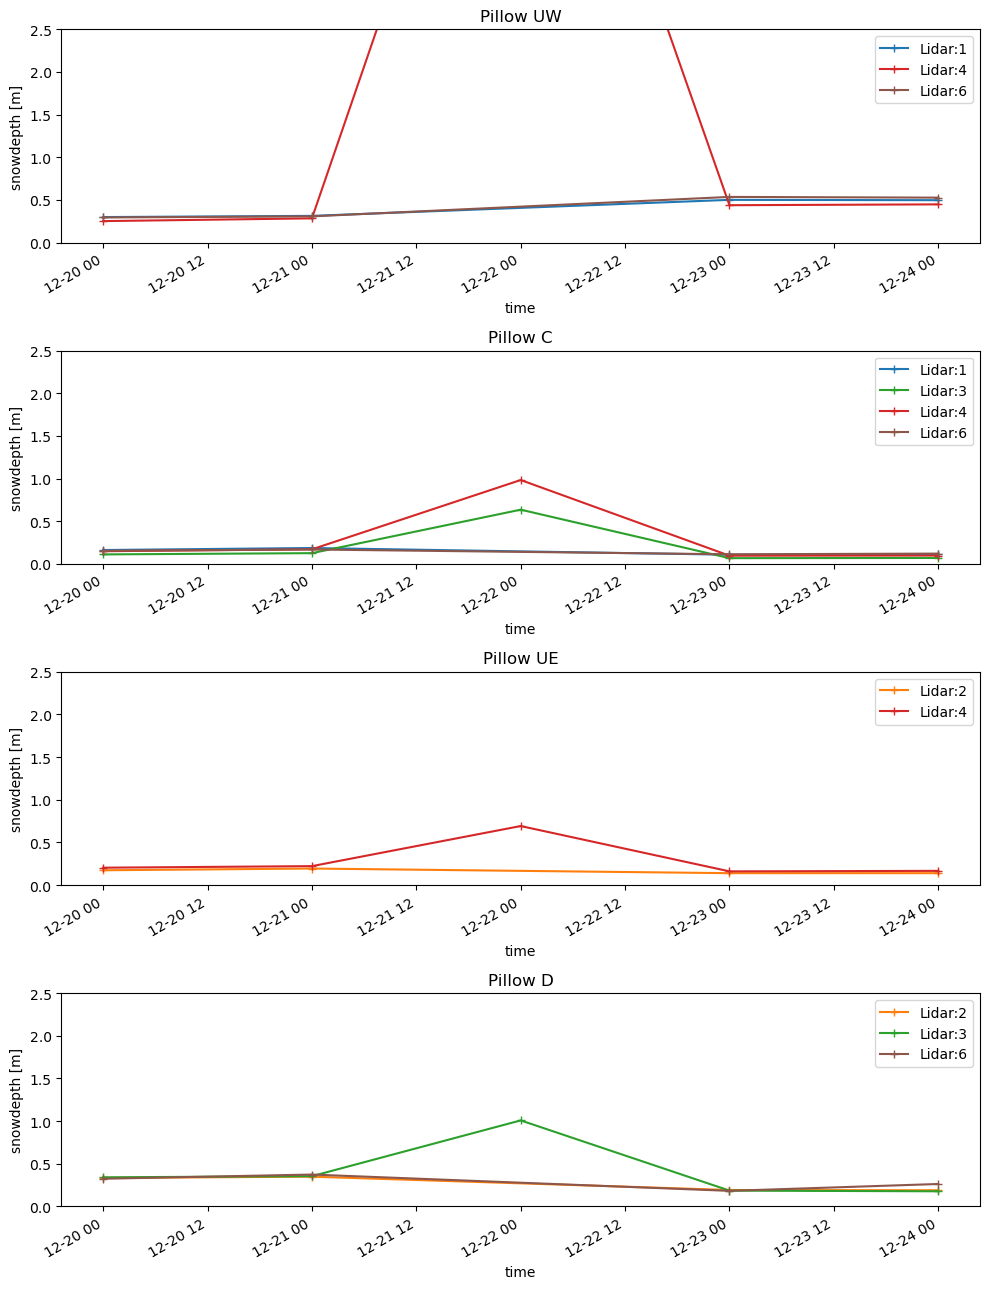

In [7]:
plt.figure(figsize=(10,13))
time_period = slice('2022-12-20','2022-12-24')
colors = [f"C{i}" for i in range(6)]
# i represents a different lidar that is observing the snow depth

pillow_list = ["UW","C","UE","D"]
# these designations indicate which snow pillow location we are measuring the depth at
# these locations, with labels, are indicated on the map shown in Module 2
# They stand for "UW = upwind west", "C = center", "UE = upwind east", and "D = downwind"

for i,p in enumerate(pillow_list):
    plt.subplot(4,1,i+1)

    for l in range(1,7):
        ds = xr.open_dataset(f"./lidar/lidar_l{l}_pillow_depths.nc")
        try:
            if p in ds["pillow"]:
                s="mean"
                ds["snowdepth"].sel(time=time_period,stat=s,pillow=p).plot(marker='+', linestyle="-", label=f"Lidar:{l}", color=colors[l-1])                
        except:
            print(f"Error with lidar {l} for pillow {p}")

    plt.ylim(0,2.5)
    plt.legend()
    plt.title(f"Pillow {p}")
    # plt.xlim(start_date, end_date)
    
plt.tight_layout()

I will be using lidar 6 as it has reasonable values for 3 out of 4 of the pillows and covers UW, which is the pillow we are interested in most. Lidar 4 has a large error on the 22nd of December, so I am not opting to use that data.

In [8]:
sos_dataset_60min_interpolated = sos_swe_60min.interp_like(lidar_6_ds)
density_uw = sos_dataset_60min_interpolated['SWE_p1_c'] / lidar_6_ds.sel(pillow='UW', stat='median')['snowdepth']
density_c = sos_dataset_60min_interpolated['SWE_p3_c'] / lidar_6_ds.sel(pillow='C', stat='median')['snowdepth']
density_d = sos_dataset_60min_interpolated['SWE_p4_c'] / lidar_6_ds.sel(pillow='D', stat='median')['snowdepth']

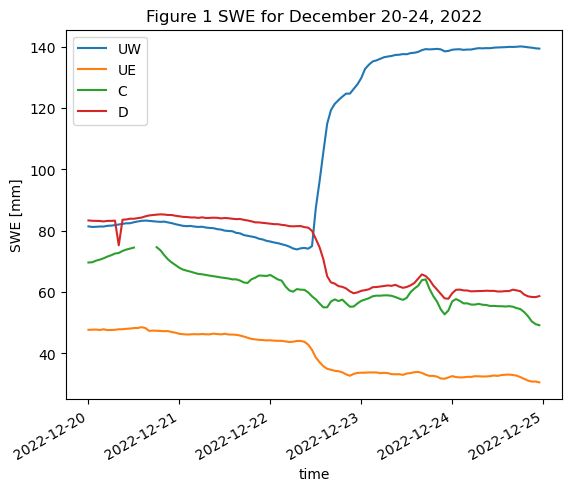

In [9]:
sos_swe_60min.sel(time=time_period)['SWE_p1_c'].plot(label='UW')
sos_swe_60min.sel(time=time_period)['SWE_p2_c'].plot(label='UE')
sos_swe_60min.sel(time=time_period)['SWE_p3_c'].plot(label='C')
sos_swe_60min.sel(time=time_period)['SWE_p4_c'].plot(label='D')
plt.title('Figure 1 SWE for December 20-24, 2022')
plt.ylabel('SWE [mm]')
plt.legend()

Text(0, 0.5, 'Daily Precipitation [mm]')

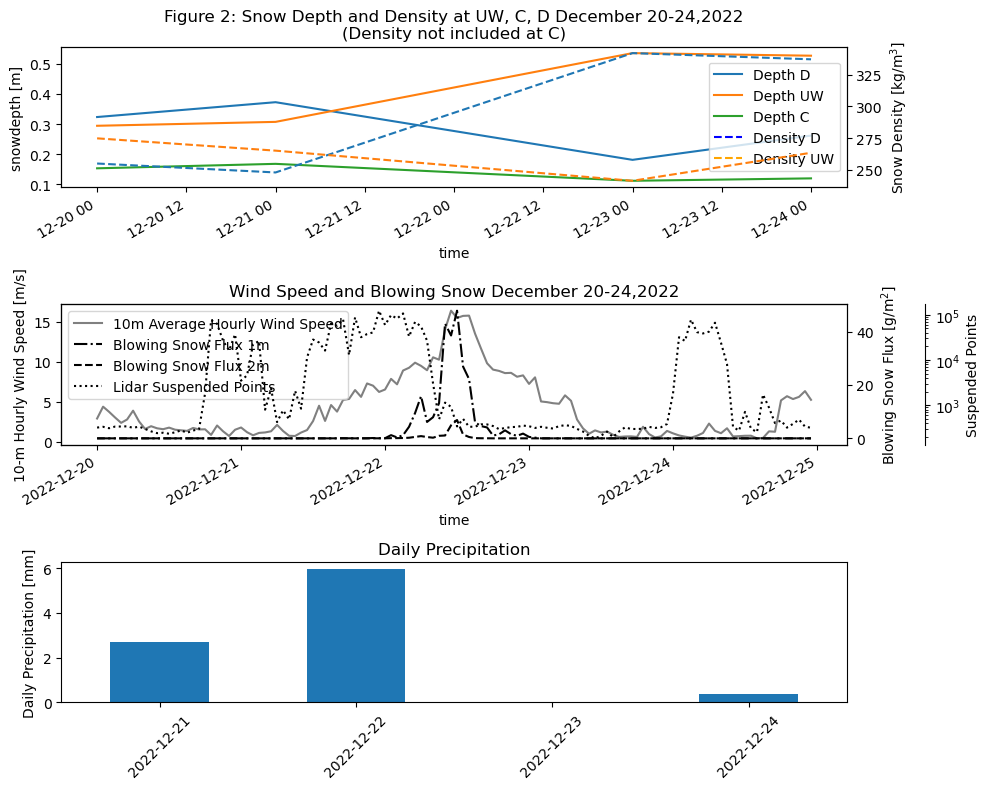

In [35]:
time_period = slice('2022-12-20','2022-12-24')

fig, axs = plt.subplots(nrows=3,figsize=(10,8), tight_layout=True)

# Plot snowdepths
lidar_6_ds.sel(time=time_period, stat='mean', pillow='D')['snowdepth'].plot(ax=axs[0], label='Depth D')
lidar_6_ds.sel(time=time_period, stat='mean', pillow='UW')['snowdepth'].plot(ax=axs[0], label='Depth UW')
lidar_6_ds.sel(time=time_period, stat='mean', pillow='C')['snowdepth'].plot(ax=axs[0], label='Depth C')
axs[0].plot([],[],label='Density D', ls='--',color='blue')
axs[0].plot([],[],label='Density UW', ls='--',color='orange')
# Plot snow densities
ax2 = axs[0].twinx()
density_d.sel(time=time_period).plot(ax=ax2,label='Density D', ls='--')
density_uw.sel(time=time_period).plot(ax=ax2,label='Density UW', ls='--')
axs[0].legend()
axs[0].set_title('Figure 2: Snow Depth and Density at UW, C, D December 20-24,2022\n(Density not included at C)')
ax2.set_title('')
ax2.set_ylabel('Snow Density [kg/m$^3$]')
# density_c.sel(time=time_period).plot(ax=ax2,label='Density C', ls='--')

# Plot wind speeds
sos_dataset_60min.sel(time=time_period)['spd_10m_ue'].plot(ax=axs[1], label='10m Average Hourly Wind Speed', color='grey')
axs[1].set_ylabel('10-m Hourly Wind Speed [m/s]')

# Plot snow particle fluxes
ax3= axs[1].twinx()
ax4=axs[1].twinx()
ax4.spines["right"].set_position(("axes", 1.1))
sos_dataset_60min.sel(time=time_period)['SF_avg_1m_ue'].plot(ax=ax3, label='FlowCapt 1m', color='k', ls='dashdot')
sos_dataset_60min.sel(time=time_period)['SF_avg_2m_ue'].plot(ax=ax3, label='FlowCapt 2m', color='k', ls='--')
particle_2_ds.sel(time=time_period)['suspended_points'].plot(ax=ax4, label='FlowCapt 2m', color='k', ls='dotted')
axs[1].plot([],[],label='Blowing Snow Flux 1m', color='k', ls='dashdot')
axs[1].plot([],[],label='Blowing Snow Flux 2m', color='k', ls='--')
axs[1].plot([],[],label='Lidar Suspended Points', color='k', ls='dotted')
ax3.set_ylabel('Blowing Snow Flux [g/m$^2$]')
ax4.set_ylabel('Suspended Points')
ax4.set_yscale('log')
axs[1].legend()
axs[1].set_title('Wind Speed and Blowing Snow December 20-24,2022')

# Precipitation
daily_precip = precip.sel(date=time_period)['acc_prec'].diff(dim='date').to_series()
daily_precip.index = precip.sel(date=time_period)['acc_prec'].diff(dim='date').to_series().index.date
daily_precip.plot.bar(ax=axs[2])
xticks = daily_precip.index
axs[2].set_xticklabels(xticks,rotation=45)
axs[2].set_title('Daily Precipitation')
axs[2].set_ylabel('Daily Precipitation [mm]')

### Discussion
The Figure 1 above shows that the UW snow pillow dramatically increased on the 22nd of December while the other pillows decreased. Looking at figure 2, we see the top plot show density and snow depth for 3 pillows (pillow c was excluded for density since the SWE data was valid with density around 700 kg/m3). As depth decreases at D and C, density increases which is a signal for wind packing and wind metamorphism driving density increases. At the UW tower we see snow depth increase and density decrease, but near the end of the time series, snow density begins to increase. I attribute this to snow being redeposited at UW at a rate that exceeds the increase in density from settlement and wind metamorphism, thus we see a drop in density. As time moves forward, density begins to increase as the snowpack settles at this location.

Moving to the second plot in Figure 2 we see a strong alignment with the timing of 10 meter wind speed peaks and the flowcapt blowing snow flux. The lidar particle counts increase prior to the main wind event. My theory is that the lidars captured a lot more falling/blowing snow particles during the snow event (reference to the bottom plot in figure 2) which are suspended much closer to the lidar, wheras the flowcapt sensors captured more of the particles saltating across the surface, the latter of which is a better representation of snow redistribution across this small area. The next set of plots below shows that the blowing snow flux did not exceed 1 for much of the winter after this event, showing how extreme this event was in terms of the entire winter. Even though wind speeds were not even the highest we've seen all winter, the fact that early season conditions were present where the surface was not yet smoothed by substantial amounts of snow lead to significant amounts of transport and localized terrain driven impacts on snow redistribution. I hypothesize that each year there may be one defining wind event that redistributes a lot of snow in the early season that works to smooth the surface, then other wind events after this major blowing snow event are damped due to the smoother surface. I think we also would have seen this with the "Santa Slammer" event in late 2021.

### Problem 2

Text(0, 0.5, 'Daily Precipitation [mm]')

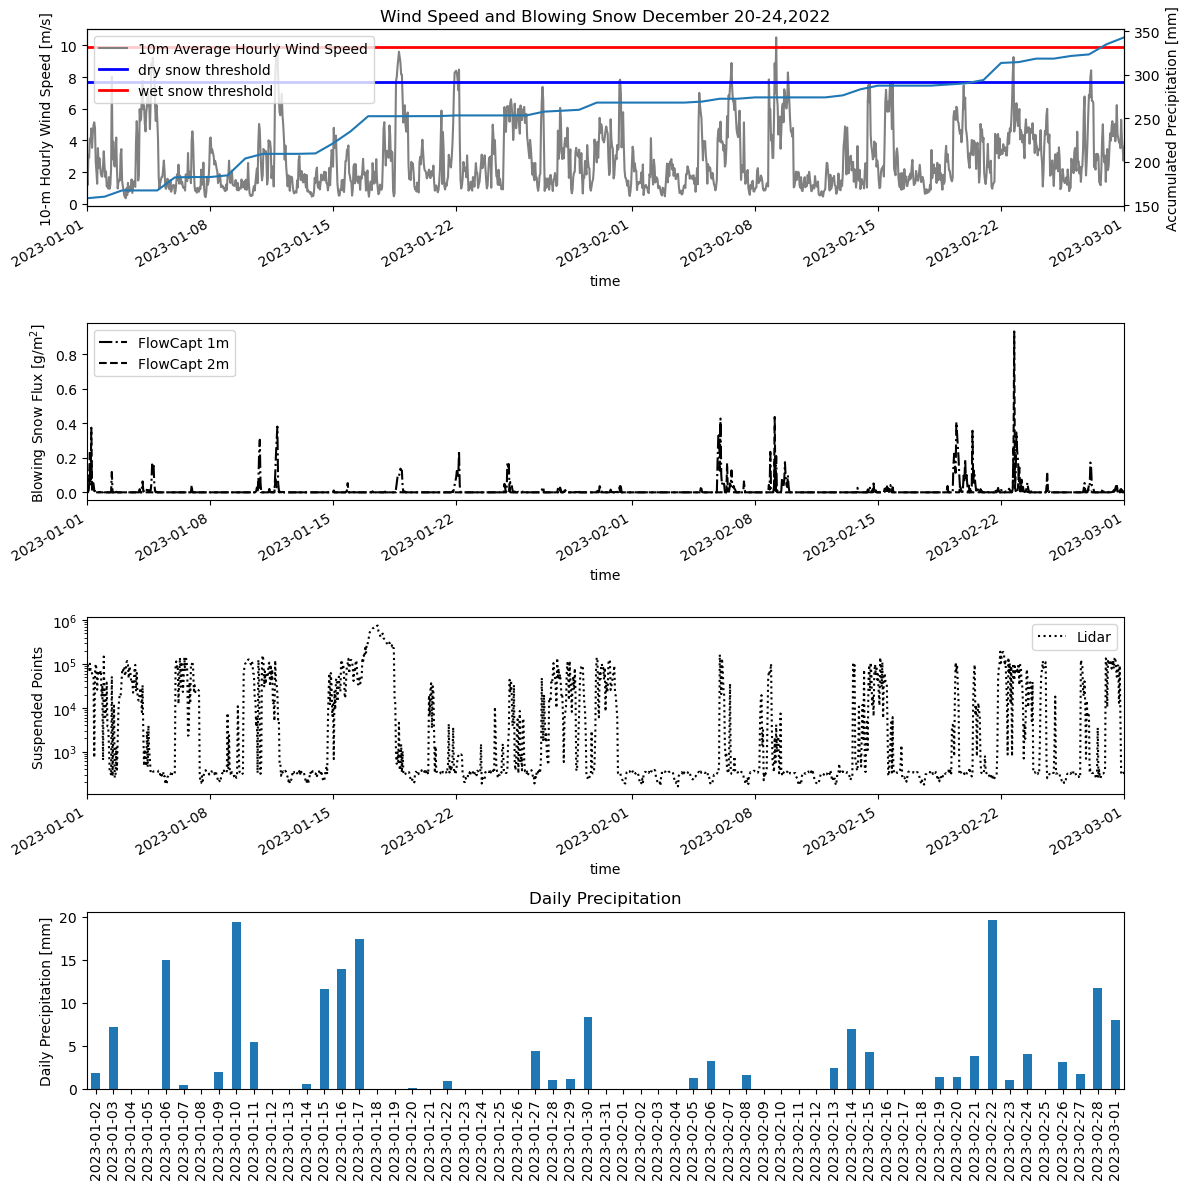

In [45]:
time_period = slice('2023-01-01','2023-03-01')

fig, axs = plt.subplots(nrows=4,figsize=(12,12), tight_layout=True)

# Plot wind speeds
# Plot snow particle fluxes
ax3= axs[0].twinx()
sos_dataset_60min.sel(time=time_period)['spd_10m_ue'].plot(ax=axs[0], label='10m Average Hourly Wind Speed', color='grey')
axs[0].set_ylabel('10-m Hourly Wind Speed [m/s]')
axs[0].set_xlim(dt.date(2023,1,1), dt.date(2023,3,1))
# Precipitation
precip.sel(date=time_period)['acc_prec'].plot(ax=ax3)
ax3.set_ylabel('Accumulated Precipitation [mm]')

# ax4=axs.twinx()
# ax4.spines["right"].set_position(("axes", 1.1))
sos_dataset_60min.sel(time=time_period)['SF_avg_1m_ue'].plot(ax=axs[1], label='FlowCapt 1m', color='k', ls='dashdot')
sos_dataset_60min.sel(time=time_period)['SF_avg_2m_ue'].plot(ax=axs[1], label='FlowCapt 2m', color='k', ls='--')
axs[1].set_xlim(dt.date(2023,1,1), dt.date(2023,3,1))
particle_2_ds.sel(time=time_period)['suspended_points'].plot(ax=axs[2], label='Lidar', color='k', ls='dotted')
axs[2].set_xlim(dt.date(2023,1,1), dt.date(2023,3,1))
axs[0].axhline(7.7, label='dry snow threshold', color='blue', lw=2)
axs[0].axhline(9.9, label='wet snow threshold', color='red', lw=2)
# axs.plot([],[],label='Blowing Snow Flux 1m', color='k', ls='dashdot')
# axs.plot([],[],label='Blowing Snow Flux 2m', color='k', ls='--')
# axs.plot([],[],label='Lidar Suspended Points', color='k', ls='dotted')
axs[1].set_ylabel('Blowing Snow Flux [g/m$^2$]')
axs[2].set_ylabel('Suspended Points')
axs[2].set_yscale('log')
axs[0].legend()
axs[1].legend()
axs[2].legend()
axs[0].set_title('Wind Speed and Blowing Snow December 20-24,2022')

# Precipitation
daily_precip = precip.sel(date=time_period)['acc_prec'].diff(dim='date').to_series()
daily_precip.index = precip.sel(date=time_period)['acc_prec'].diff(dim='date').to_series().index.date
daily_precip.plot.bar(ax=axs[3])
xticks = daily_precip.index
axs[3].set_xticklabels(xticks,rotation=90)
axs[3].set_title('Daily Precipitation')
axs[3].set_ylabel('Daily Precipitation [mm]')


The figure above shows average hourly 10-m wind speed, blowing snow flux and 1 and 2 meters, lidar suspended particle counts, and accumulated precipitation over 2 months of data from January 1 to March 1, 2023 along with the blowing snow thresholds from Li and Pomeroy (1997). While blowing snow signals in the blowing snow flux and particle counter generally align with the periods when wind speeds are above the threholds, the above threshold periods are short and somewhat rare. The lidar retrievals also are quite sensitive to signals from falling snow, and show a lot more periods of high particle counts than the blowing snow flux. Looking at a distribution of wind speeds (plotted below as a histogram) shows just how rare they are. It appears that at this site, the blowing snow thresholds should be lower. Speaking from experience, we saw plenty of snow transport over the winter season occuring at relatively low wind speeds. The largest signals came right after snow events as new snow deposited and was ripe for transport. Interestingly, in a lot of events over the season, the a lot of windier periods occured after snow events.

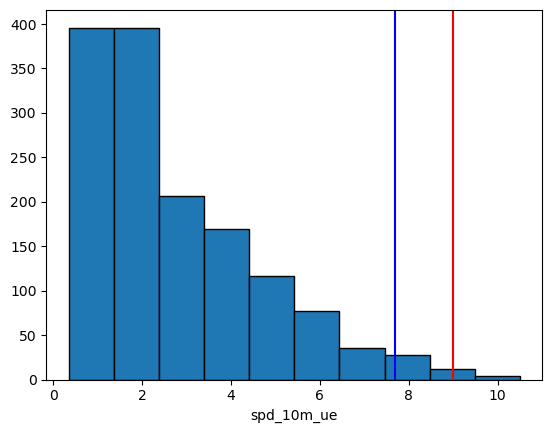

In [12]:
fig, ax = plt.subplots()
sos_dataset_60min.sel(time=time_period)['spd_10m_ue'].plot.hist(ax=ax, ec='k');
ax.axvline(7.7, color='blue', label='wet snow threhold')
ax.axvline(9, color='red', label='dry snow threhold')


### Project Update

I have started to work with building a way to download our snowpit data to look at temperature and density profiles. Below, I plotted an example of density and temperature from March 14, 2023

In [30]:
import pandas as pd
fn = "KP46-14-Mar.xml"

tmp_profile = pd.read_xml(fn)['temp_profile'].iloc[-1]
depths_T = [float(j[0]) for j in [i.split(":") for i in tmp_profile.split(';')]]
temps = [float(j[1]) for j in [i.split(":") for i in tmp_profile.split(';')]]
temp_df = pd.Series(temps, index=depths_T)

density_profile = pd.read_xml(fn)['profile'].iloc[-2]
depths_rho = [float(j[0]) for j in [i.split(":") for i in density_profile.split(';')]]
density = [float(j[1]) for j in [i.split(":") for i in density_profile.split(';')]]
density_df = pd.Series(density, index=depths_rho)

Text(0.5, 1.0, 'Example Snow Pit Density Profile\nMar 14 2023')

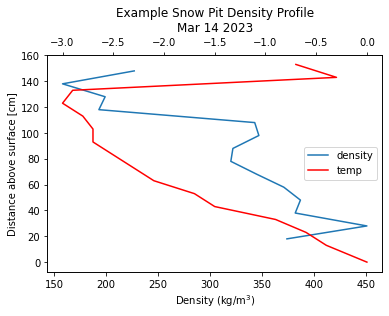

In [36]:
import matplotlib.pyplot as plt
plt.plot(density_df,density_df.index, label='density')
plt.plot([],[], color='r', label='temp')
plt.xlabel("Density (kg/m$^3$)")
plt.ylabel("Distance above surface [cm]")
plt.legend(loc='center right')
plt.twiny()
plt.plot(temp_df,temp_df.index, color='r', label='temp')
plt.ylabel("Temperature C")
plt.title("Example Snow Pit Density Profile\nMar 14 2023")